# Burgers - identification

*2023-11-25*

Based on: <https://github.com/maziarraissi/PINNs/tree/master/appendix/continuous_time_identification%20(Burgers)>

## Libraries & Setup

In [1]:
%env TF_CPP_MIN_LOG_LEVEL=3
import numpy as np
import scipy.io
from scipy.interpolate import griddata
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
import time
import logging
import os

import matplotlib.pyplot as plt
my_rc_param = {'text.usetex': False}
plt.rcParams.update(my_rc_param)

import tensorflow as tf
logging.disable(logging.WARNING)
logging.getLogger('tensorflow').disabled = True
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Prevent tensorflow from allocating all GPU memory
configuration = tf.compat.v1.ConfigProto()
configuration.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=configuration)

# For reproducibility
np.random.seed(1234)
tf.compat.v1.set_random_seed(1234)

env: TF_CPP_MIN_LOG_LEVEL=3


## Hyperparameters and other parameters

In [2]:
nu = 0.01/np.pi

N_u = 2000

layers = [2, 40, 40, 40, 40, 40, 40, 1]

data = scipy.io.loadmat('burgers_shock.mat')

## Plotting module

In [3]:
def figsize(scale, nplots=1):
    fig_width_pt = 390.0  # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0 / 72.27  # Convert pt to inch

    # Aesthetic ratio (you could change this)
    golden_mean = (np.sqrt(5.0) - 1.0) / 2.0

    fig_width = fig_width_pt * inches_per_pt * scale  # width in inches
    fig_height = nplots * fig_width * golden_mean  # height in inches
    fig_size = [fig_width, fig_height]
    return fig_size

def newfig(width, nplots=1):
    # fig = plt.figure(figsize=figsize(width, nplots)) #latex
    fig = plt.figure()
    ax = fig.add_subplot(111)
    return fig, ax

## PINN

L-BFGS-B parameters
<https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html>
- *maxiter* - Maximum number of iterations.
- *maxfun* - maximum number of function evaluations. Note that this function may violate the limit because of evaluating gradients by numerical differentiation.
- *maxcor* - the maximum number of variable metric corrections used to define the limited memory matrix. (The limited memory BFGS method does not store the full hessian but uses this many terms in an approximation to it.)
- *ftol* - the iteration stops when $(f^k - f^{k+1})/max{|f^k|,|f^{k+1}|,1}$ <= ftol.
- *maxls* - maximum number of line search steps (per iteration). Default is 20.

In [4]:
class PhysicsInformedNN:

    # Initialize the class
    def __init__(self, X, u, layers, lb, ub):
        self.lb = lb
        self.ub = ub
        self.x = X[:, 0:1]
        self.t = X[:, 1:2]
        self.u = u
        self.layers = layers
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        # Initialize parameters
        self.lambda_1 = tf.Variable([0.0], dtype=tf.float32)
        self.lambda_2 = tf.Variable([-6.0], dtype=tf.float32)
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]])
        self.u_tf = tf.placeholder(tf.float32, shape=[None, self.u.shape[1]])
        self.u_pred = self.net_u(self.x_tf, self.t_tf)
        self.f_pred = self.net_f(self.x_tf, self.t_tf)
        self.loss = ( tf.reduce_mean(tf.square(self.u_tf - self.u_pred)) +
            tf.reduce_mean(tf.square(self.f_pred)) )
        # https://docs.scipy.org/doc/scipy/reference/optimize.minimize-lbfgsb.html
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(
            self.loss,
            method='L-BFGS-B',
            options={
                'maxiter': 50000,
                'maxfun': 50000,
                'maxcor': 50,
                'maxls': 50,
                'ftol': 1.0 * np.finfo(float).eps
            })
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):
        weights = []
        biases = []
        num_layers = len(layers)
        for l in range(0, num_layers - 1):
            W = self.xavier_init(size=[layers[l], layers[l + 1]])
            b = tf.Variable(tf.zeros([1, layers[l + 1]], dtype=tf.float32),
                            dtype=tf.float32)
            weights.append(W)
            biases.append(b)
        return weights, biases

    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]
        xavier_stddev = np.sqrt(2 / (in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim],
                                               stddev=xavier_stddev),
                           dtype=tf.float32)

    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0 * (X - self.lb) / (self.ub - self.lb) - 1.0
        for l in range(0, num_layers - 2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def net_u(self, x, t):
        u = self.neural_net(tf.concat([x, t], 1), self.weights, self.biases)
        return u

    def net_f(self, x, t):
        lambda_1 = self.lambda_1
        lambda_2 = tf.exp(self.lambda_2)
        u = self.net_u(x, t)
        u_t = tf.gradients(u, t)[0]
        u_x = tf.gradients(u, x)[0]
        u_xx = tf.gradients(u_x, x)[0]
        f = u_t + lambda_1 * u * u_x - lambda_2 * u_xx
        return f

    def callback(self, loss, lambda_1, lambda_2):
        #print('Loss: %e, l1: %.5f, l2: %.5f' % (loss, lambda_1, np.exp(lambda_2)))
        pass

    def train(self, nIter):
        tf_dict = {self.x_tf: self.x, self.t_tf: self.t, self.u_tf: self.u}
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                lambda_1_value = self.sess.run(self.lambda_1)
                lambda_2_value = np.exp(self.sess.run(self.lambda_2))
                print(
                    'It: %d, Loss: %.3e, Lambda_1: %.3f, Lambda_2: %.6f, Time: %.2f'
                    % (it, loss_value, lambda_1_value, lambda_2_value, elapsed))
                start_time = time.time()

        self.optimizer.minimize(
            self.sess,
            feed_dict=tf_dict,
            fetches=[self.loss, self.lambda_1, self.lambda_2],
            loss_callback=self.callback
        )

    def predict(self, X_star):
        tf_dict = {self.x_tf: X_star[:, 0:1], self.t_tf: X_star[:, 1:2]}
        u_star = self.sess.run(self.u_pred, tf_dict)
        f_star = self.sess.run(self.f_pred, tf_dict)
        return u_star, f_star

## Main

In [5]:
t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Doman bounds
lb = X_star.min(0)
ub = X_star.max(0)

idx = np.random.choice(X_star.shape[0], N_u, replace=False)
X_u_train = X_star[idx, :]
u_train = u_star[idx, :]

## Model

In [6]:
%%time
model = PhysicsInformedNN(X_u_train, u_train, layers, lb, ub)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:1 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:2 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:3 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: Tesla V100-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:1 -> device: 1, name: Tesla V100-PCIE-32GB, pci bus id: 0000:5e:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:2 -> device: 2, name: Tesla V100-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0
/job:localhost/replica:0/task:0/device:GPU:3 -> device: 3, name: Tesla V100-PCIE-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_C

## Train (the compute intensive part)

In [7]:
%%time
model.train(0)

CPU times: user 1min 3s, sys: 7.32 s, total: 1min 11s
Wall time: 37.2 s


## Predict

In [8]:
u_pred, f_pred = model.predict(X_star)
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')

## Error

In [9]:
error_u = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
lambda_1_value = model.sess.run(model.lambda_1)
lambda_2_value = model.sess.run(model.lambda_2)
lambda_2_value = np.exp(lambda_2_value)
error_lambda_1 = np.abs(lambda_1_value - 1.0) * 100
error_lambda_2 = np.abs(lambda_2_value - nu) / nu * 100
print('Error u: %e' % (error_u))
print('Error l1: %.5f%%' % (error_lambda_1))
print('Error l2: %.5f%%' % (error_lambda_2))

Error u: 8.377410e-04
Error l1: 0.02811%
Error l2: 0.32131%


## Plotting

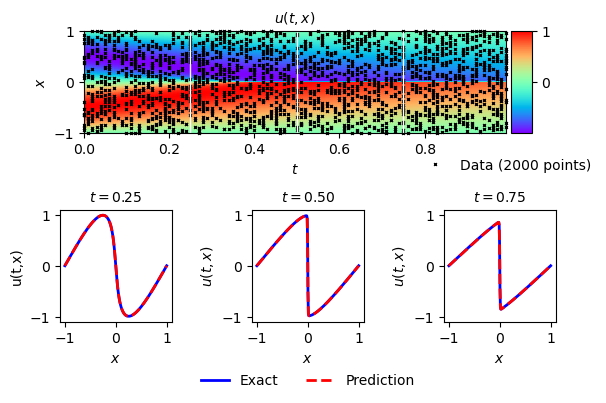

In [10]:
fig, ax = newfig(1.0, 1.4)
ax.axis('off')

# u(t,x)

gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1 - 0.06,
           bottom=1 - 1.0 / 3.0 + 0.06,
           left=0.15,
           right=0.85,
           wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T,
              interpolation='nearest',
              cmap='rainbow',
              extent=[t.min(), t.max(), x.min(),
                      x.max()],
              origin='lower',
              aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_u_train[:, 1],
        X_u_train[:, 0],
        'kx',
        label='Data (%d points)' % (u_train.shape[0]),
        markersize=2,
        clip_on=False)

line = np.linspace(x.min(), x.max(), 2)[:, None]
ax.plot(t[25] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[50] * np.ones((2, 1)), line, 'w-', linewidth=1)
ax.plot(t[75] * np.ones((2, 1)), line, 'w-', linewidth=1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(loc='upper center',
          bbox_to_anchor=(1.0, -0.125),
          ncol=5,
          frameon=False)
ax.set_title('$u(t,x)$', fontsize=10)

# u(t,x) slices

gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1 - 1.0 / 3.0 - 0.1,
           bottom=1.0 - 2.0 / 3.0,
           left=0.1,
           right=0.9,
           wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x, Exact[25, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[25, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('u(t,x)')
ax.set_title('$t = 0.25$', fontsize=10)
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x, Exact[50, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[50, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.50$', fontsize=10)
ax.legend(loc='upper center',
          bbox_to_anchor=(0.5, -0.35),
          ncol=5,
          frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x, Exact[75, :], 'b-', linewidth=2, label='Exact')
ax.plot(x, U_pred[75, :], 'r--', linewidth=2, label='Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1, 1.1])
ax.set_ylim([-1.1, 1.1])
ax.set_title('$t = 0.75$', fontsize=10)

plt.show()

### Identified PDE

In [11]:
print(r'Correct PDE: u_t + u u_x - 0.0031831 u_{xx} = 0')
print(r'Identified PDE (clean data): ',
      r'u_t + %.5f u u_x - %.7f u_{xx} = 0' % (lambda_1_value, lambda_2_value))

Correct PDE: u_t + u u_x - 0.0031831 u_{xx} = 0
Identified PDE (clean data):  u_t + 0.99972 u u_x - 0.0031933 u_{xx} = 0
